# Zero-To-Hero Lecture 1: MicroGrad

### Andrej Karpathy Lecture Series

In [1]:
### Import Dependencies

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Motivation

In [7]:
h  = 0.0001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
#a += h #increment parameter a by h
b += h #increment parameter b by h
#c += h #increment parameter c by h
d2 = a*b + c
print('d1:', d1)
print('d2:', d2)
print('Slope wrt to b:',  (d2-d1)/h) #Slope wrt to is the same as partial derivative

d1: 4.0
d2: 4.0002
Slope wrt to b: 2.0000000000042206


Going from simple derivatives of single valued functions, the above example illustrates how we can use computation to approximate the derivatives of arbitrary functions by simply using the basic definition of the derivative to perturb parameters and measure the change in the output of the overall function.

In [91]:
### First Pass To Design Base Functionaly

class SV1:
    """
    Implements the wrapper class around scalar values that allows
    for the general computation of scalars, while also keeping track 
    of the computational graph for efficient backpropagation through
    arbitrary unary? operations.
    
    V1: This carries the forward prop for addition and multiplication
    """

    
    def __init__(
        self, 
        value,
        _prevs=(),
        _gen_op = '',
        label = '',
    ):
        self.value = value #Scalar number 
        self.label = label # Label for reference
        self.grad = 0.0 # Initialize gradients to zero 
        self._prev = set(_prevs) # The previous SVs that were combined using the gen_op
        self._gen_op = _gen_op # The operation that yielded this SV object (string)
        
        
    def __repr__(self):
        """
        Repr is the function that python internally calls for the representation 
        of the object in the python interpreter
        
        Returns Value(data=SOME NUMBER) instead of 
        <__main__.Value at SOME HASH>
        """
        return f"SV1(value={self.value})"
    
    
    def __add__(self, x):
        """
        Wrapper around the python built in addition operator
        
        Inputs:
            Self: Value Object
            X: another Value object
        Outputs:
            Out: Value object containing scalar sum of self and x
        """
        out = SV1(self.value + x.value, (self, x), '+')
        return out
    
    
    def __mul__(self, x):
        """
        Wrapper around the python built in multiplication operator
        
        Inputs:
            Self: Value Object
            X: another Value object
        Outputs:
            Out: Value object containing scalar sum of self and x
        """
        out = SV1(self.value * x.value, (self, x), '*')
        return out

### Visualizing the Computational Graph

In [92]:
from graphviz import Digraph

def trace(root):
    """
    Trace path from root to multiple leaf nodes
    """
    nodes = set()
    edges = set()
    def build(v):
        """
        Recursively build the graph from v
        """
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left right
    
    nodes,edges = trace(root)
    for n in nodes:
        pid = str(id(n))
        # For all values in the graph create a 'record' node for it
        dot.node(name=pid, label="{ %s | value %.4f | grad %.4f }" % (n.label, n.value, n.grad), shape='record')
        if n._gen_op: # Check to see if this value was created by an operation
            op = n._gen_op # Create a new node and edge between values and op
            dot.node(name = pid + op, label=op) # Creat new node for op
            dot.edge(pid + op, pid) # Connect new dot and old dot
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._gen_op)
        
    return dot

#### Single Neuron Example

In [93]:
# Forward Pass through the Neuron
x1 = SV1(2.0, label='x1')
x2 = SV1(0.0, label='x2')
w1 = SV1(-3.0, label='w1')
w2 = SV1(1.0, label='w2')
b = SV(6.8813735, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
addr = x1w1 + x2w2; addr.label = 'x1w1+x2w2'
n = addr + b; n.label='n'

In [94]:
# Backpropagate by Hand for Practice

n.grad = 1 # dndn = 1
addr.grad = 1 # dn/daddr = 1
b.grad = 1 #dn/db  = 1
x1w1.grad = 1 * addr.grad # dn/dx1w1 = dn/daddr * daddr/dx1w1
x2w2.grad = 1 * addr.grad # dn/dx2w2 = dn/daddr * daddr/dx2w2
x1.grad = w1.value * x1w1.grad # dn/dx1 = dn/daddr * daddr/dx1w1 * dx1w1/dx1
w1.grad = x1.value * x1w1.grad # dn/dw1 = dn/daddr * daddr/dx1w1 * dx1w1/dw1
x2.grad = w2.value * x2w2.grad # dn/dx2 = dn/daddr * daddr/dx2w2 * dx2w2/dx2
w2.grad = x2.value * x2w2.grad # dn/dw2 = dn/daddr * daddr/dx2w2 * dx2w2/dw2

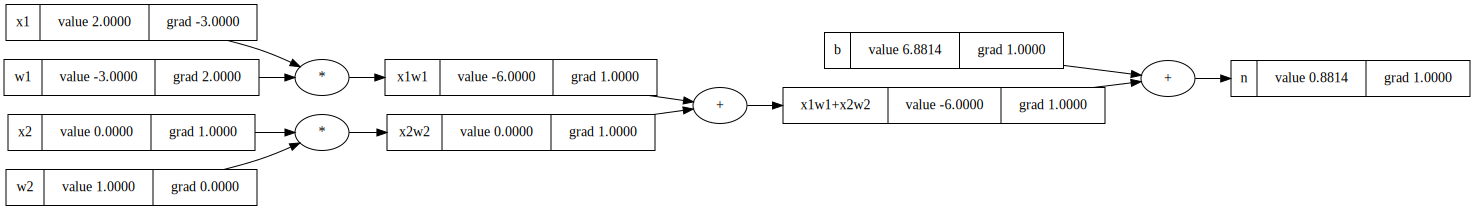

In [95]:
draw_dot(n)

In [96]:
# CHeck Random Unit
# x1 grad should equal -3
def testfn_helper(h):
    x1 = SV1(2.0 + h, label='x1')
    x2 = SV1(0.0, label='x2')
    w1 = SV1(-3.0, label='w1')
    w2 = SV1(1.0, label='w2')
    b = SV(6.8813735, label='b')
    x1w1 = x1*w1; x1w1.label = 'x1w1'
    x2w2 = x2*w2; x2w2.label = 'x2w2'
    addr = x1w1 + x2w2; addr.label = 'x1w1+x2w2'
    n = addr + b; n.label='n'
    return n.value

def testfn(h):
    # Forward Pass through the Neuron
    n1 = testfn_helper(h)
    n2 = testfn_helper(0)
    
    return (n1-n2)/h
    
testfn(.00001)

-3.000000000064062

In [167]:
class SV2:
    """
    Implements the wrapper class around scalar values that allows
    for the general computation of scalars, while also keeping track 
    of the computational graph for efficient backpropagation through
    arbitrary unary? operations.
    
    V2: This adds the gradient tape for backprop for addition and multiplication
    Includes bug fix for accumulating gradients instead of setting gradients
    """

    
    def __init__(
        self, 
        value,
        _prevs=(),
        _gen_op = '',
        label = '',
    ):
        self.value = value #Scalar number 
        self.label = label # Label for reference
        self.grad = 0.0 # Initialize gradients to zero 
        self._backward = lambda: None # Do nothing when initializing a value
        self._prev = set(_prevs) # The previous SVs that were combined using the gen_op
        self._gen_op = _gen_op # The operation that yielded this SV object (string)
        
        
    def __repr__(self):
        """
        Repr is the function that python internally calls for the representation 
        of the object in the python interpreter
        
        Returns Value(data=SOME NUMBER) instead of 
        <__main__.Value at SOME HASH>
        """
        return f"SV2(value={self.value} | label={self.label})"
    
    def backward(self):
        
        ### Topological Sort
        def topological_sort(root):
            topo = []
            visited_nodes = set()
            def construct(v):
                if v not in visited_nodes:
                    visited_nodes.add(v)
                    for parent in v._prev:
                        # Execute all the recursive calls until leaf nodes are hit
                        construct(parent)
                    # Collect all the leaf nodes and add them to list in order of shallowest leaf -> deepest
                    topo.append(v)
            construct(root)
            return topo
        
        topo = topological_sort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def __add__(self, x):
        """
        Wrapper around the python built in addition operator
        
        Inputs:
            Self: Value Object
            X: another Value object
        Outputs:
            Out: Value object containing scalar sum of self and x
        """
        out = SV2(self.value + x.value, (self, x), '+', label=self.label+'+'+x.label )
        
        def _backward():
            self.grad += 1.0 * out.grad
            x.grad += 1.0 * out.grad
        
        out._backward = _backward
        
        return out
    
    
    def __mul__(self, x):
        """
        Wrapper around the python built in multiplication operator
        
        Inputs:
            Self: Value Object
            X: another Value object
        Outputs:
            Out: Value object containing scalar sum of self and x
        """
        out = SV2(self.value * x.value, (self, x), '*', label=self.label+x.label)
        
        def _backward():
            self.grad += x.value * out.grad
            x.grad += self.value * out.grad
        
        out._backward = _backward
        
        return out

In [168]:
# Forward Pass through the Neuron
x1 = SV2(2.0, label='x1')
x2 = SV2(0.0, label='x2')
w1 = SV2(-3.0, label='w1')
w2 = SV2(1.0, label='w2')
b = SV2(6.8813735, label='b')
x1w1 = x1*w1
x2w2 = x2*w2
addr = x1w1 + x2w2
n = addr + b

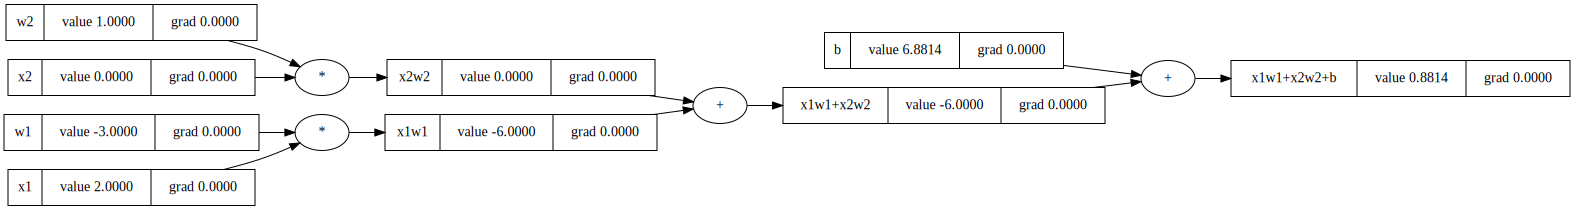

In [169]:
draw_dot(n)

In [170]:
n.grad = 1

In [171]:
n._backward()

In [172]:
addr._backward()

In [173]:
x1w1._backward()

In [174]:
x2w2._backward()

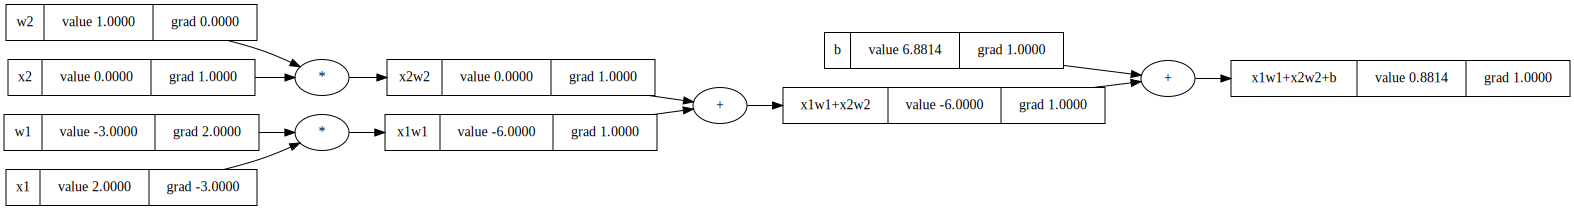

In [175]:
draw_dot(n)

### Automatically Parsing the Computational Graph

In [176]:
### Topological Sort
def topological_sort(root):
    topo = []
    visited_nodes = set()
    def construct(v):
        if v not in visited_nodes:
            visited_nodes.add(v)
            for parent in v._prev:
                # Execute all the recursive calls until leaf nodes are hit
                construct(parent)
            # Collect all the leaf nodes and add them to list in order of shallowest leaf -> deepest
            topo.append(v)
    construct(root)
    return topo

In [177]:
topological_sort(n)

[SV2(value=6.8813735 | label=b),
 SV2(value=1.0 | label=w2),
 SV2(value=0.0 | label=x2),
 SV2(value=0.0 | label=x2w2),
 SV2(value=2.0 | label=x1),
 SV2(value=-3.0 | label=w1),
 SV2(value=-6.0 | label=x1w1),
 SV2(value=-6.0 | label=x1w1+x2w2),
 SV2(value=0.8813734999999996 | label=x1w1+x2w2+b)]

In [178]:
list(reversed(topological_sort(n)) )

[SV2(value=0.8813734999999996 | label=x1w1+x2w2+b),
 SV2(value=-6.0 | label=x1w1+x2w2),
 SV2(value=-6.0 | label=x1w1),
 SV2(value=-3.0 | label=w1),
 SV2(value=2.0 | label=x1),
 SV2(value=0.0 | label=x2w2),
 SV2(value=0.0 | label=x2),
 SV2(value=1.0 | label=w2),
 SV2(value=6.8813735 | label=b)]

In [179]:
for node in topological_sort(n):
    node.grad = 0.0 # Clear manually computed gradients and then automatically compute
n.backward()

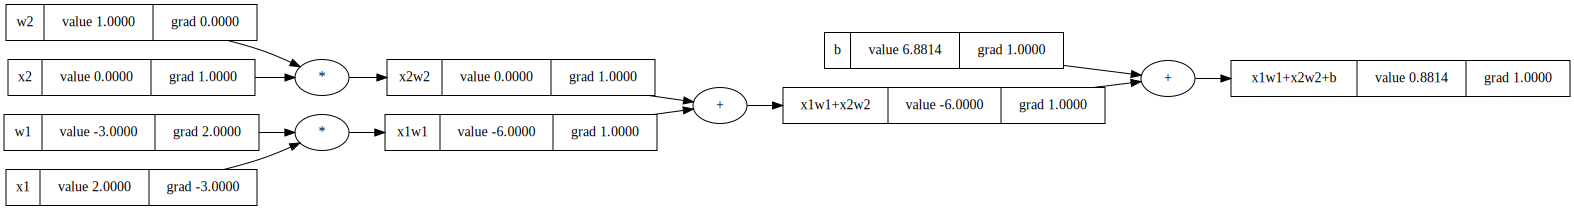

In [180]:
draw_dot(n)

### Squashing a Bug

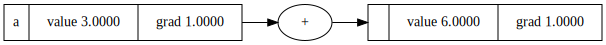

In [182]:
a = SV1(3.0, label='a')
b = a + a
b.grad = 1
a.grad = 1
draw_dot(b)

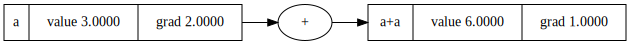

In [184]:
a = SV2(3.0, label='a')
b = a + a
b.backward() # With accumulated gradients
draw_dot(b)

In [187]:
x = SV2(value=2.0, label='x')
x2 = x*x
y = SV2(value=1.0, label='y')
y2 = y*y
o = x2 + y2

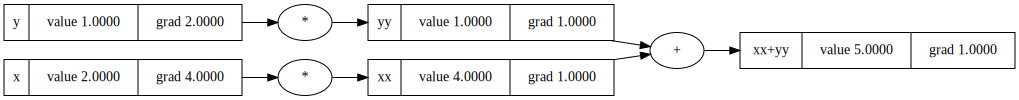

In [189]:
o.backward()
draw_dot(o)

In [192]:
#Check 

x = SV2(value=2.0, label='x')
x2 = x*x
y = SV2(value=1.0, label='y')
y2 = y*y
o1 = x2 + y2

h = .000001
x1 = SV2(value=2.0+h, label='x')
x12 = x1*x1
o2 = x12 + y2

print((o2.value-o1.value)/h)

4.0000010006480125


In [ ]:
class SV3:
    """
    Implements the wrapper class around scalar values that allows
    for the general computation of scalars, while also keeping track 
    of the computational graph for efficient backpropagation through
    arbitrary unary? operations.
    
    V2: This adds the gradient tape for backprop for addition and multiplication
    Includes bug fix for accumulating gradients instead of setting gradients
    """

    
    def __init__(
        self, 
        value,
        _prevs=(),
        _gen_op = '',
        label = '',
    ):
        self.value = value #Scalar number 
        self.label = label # Label for reference
        self.grad = 0.0 # Initialize gradients to zero 
        self._backward = lambda: None # Do nothing when initializing a value
        self._prev = set(_prevs) # The previous SVs that were combined using the gen_op
        self._gen_op = _gen_op # The operation that yielded this SV object (string)
        
        
    def __repr__(self):
        """
        Repr is the function that python internally calls for the representation 
        of the object in the python interpreter
        
        Returns Value(data=SOME NUMBER) instead of 
        <__main__.Value at SOME HASH>
        """
        return f"SV3(value={self.value} | label={self.label})"
    
    def backward(self):
        
        ### Topological Sort
        def topological_sort(root):
            topo = []
            visited_nodes = set()
            def construct(v):
                if v not in visited_nodes:
                    visited_nodes.add(v)
                    for parent in v._prev:
                        # Execute all the recursive calls until leaf nodes are hit
                        construct(parent)
                    # Collect all the leaf nodes and add them to list in order of shallowest leaf -> deepest
                    topo.append(v)
            construct(root)
            return topo
        
        topo = topological_sort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def __add__(self, x):
        """
        Wrapper around the python built in addition operator
        
        Inputs:
            Self: Value Object
            X: another Value object
        Outputs:
            Out: Value object containing scalar sum of self and x
        """
        out = SV3(self.value + x.value, (self, x), '+', label=self.label+'+'+x.label )
        
        def _backward():
            self.grad += 1.0 * out.grad
            x.grad += 1.0 * out.grad
        
        out._backward = _backward
        
        return out
    
    
    def __mul__(self, x):
        """
        Wrapper around the python built in multiplication operator
        
        Inputs:
            Self: Value Object
            X: another Value object
        Outputs:
            Out: Value object containing scalar sum of self and x
        """
        out = SV3(self.value * x.value, (self, x), '*', label=self.label+x.label)
        
        def _backward():
            self.grad += x.value * out.grad
            x.grad += self.value * out.grad
        
        out._backward = _backward
        
        return out

In [193]:
x = SV2(value  = 2.0, label='x')
y = SV2(value  = 1.0, label='y')

o = x*x + y*y

In [195]:
o.backward()

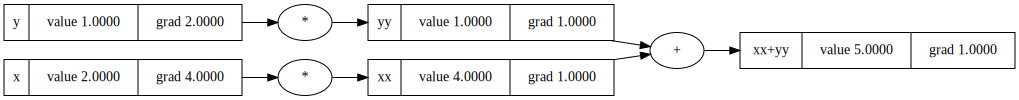

In [196]:
draw_dot(o)